# 🔬 CLE Image Segmentation

Notebook for creating a machine learning model for segmenting the larynx opening from a CLE-test video frame.

## 📦 Imports

Mount Google Drive if using Colab

In [ ]:
try:
  import google.colab
  is_colab = True
except:
  is_colab = False

if is_colab:
  from google.colab import drive
  drive.mount('/content/drive')

Mounted at /content/drive


All imports necessary to run the notebook

In [ ]:
from fastai import *
from fastai.vision.all import *
import os
from pathlib import Path
import torch
import numpy as np
from pycocotools.coco import COCO
from pycocotools import mask as maskUtils
import matplotlib.pyplot as plt
import zipfile

## 📌 Paths

Defining the path of the training and test data

In [ ]:
data_dir = './drive/MyDrive/Machine Learning/ML datasets/cle_images'
os.listdir(data_dir)

['data_0.1.zip',
 'data_0.2.zip',
 'data_0.3.zip',
 'data_0.4.zip',
 'data_0.5.zip',
 'next_frame_test.zip',
 'test_data_0.1.zip',
 'data_0.6.zip',
 'test_data_0.2.zip',
 'next_frame_test_0.2.zip']

Function for extracting data from a zip file

In [ ]:
def unzip_data(zip_file_name):
  with zipfile.ZipFile(f'{data_dir}/{zip_file_name}.zip', 'r') as zip_ref:
      zip_ref.extractall(zip_file_name)
  return Path(zip_file_name)

Defining the path of the data for training (images and masks). The image folder contains all the training images. The 'result.json' file defines the masks for each of the images in a COCO file format.

In [ ]:
data_path = unzip_data('data_0.6')
images = data_path/'images'
mask_data = data_path/'result.json'

Same for test data

In [ ]:
test_set_path = unzip_data('test_data_0.2')
test_images_path = test_set_path/'images'
test_mask_data = test_set_path/'result.json'

## 🎭 Masks

Using pycocotools for extracting the mask data from the coco-file

In [ ]:
coco_annotations = COCO(mask_data)
coco_annotations_test = COCO(test_mask_data)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Defining some variables to store information from the coco-file

In [ ]:
coco_imgs = coco_annotations.imgs
img_dict = dict(coco_imgs)
test_img_dict = dict(coco_annotations_test.imgs)
img_ids = coco_annotations.getImgIds()
cat_ids = coco_annotations.getCatIds()
annotation_ids = coco_annotations.getAnnIds(img_ids, catIds=cat_ids, iscrowd=None)
annotations = coco_annotations.loadAnns(annotation_ids)

Plotting all the masks from the training data

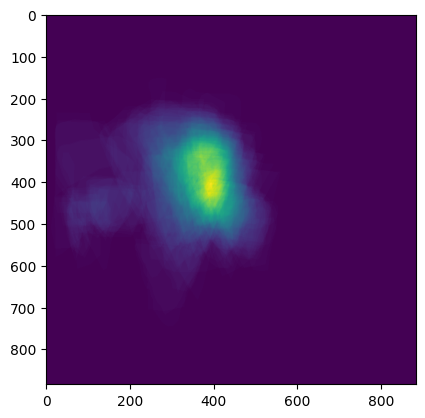

In [ ]:
all_masks = coco_annotations.annToMask(annotations[0])

for i in range(len(annotations)):
    if i > 0: all_masks += coco_annotations.annToMask(annotations[i])

plt.imshow(all_masks)

Plotting single mask

<Axes: >

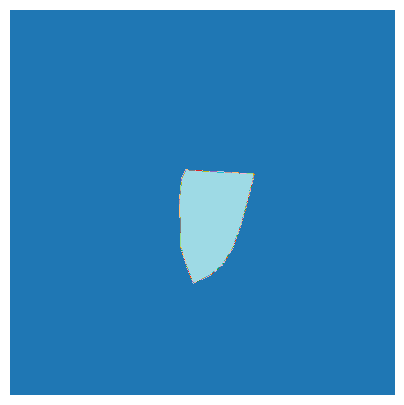

In [ ]:
mask = coco_annotations.annToMask(annotations[15])
mask_tensor = tensor(mask)
pil_mask = PILMask.create(mask_tensor)
pil_mask.show(figsize=(5,5), alpha=1)

Function for printing a mask wrapped in a Tensor

In [ ]:
def print_tensor_mask(tensor_mask):
  pil_mask = PILMask.create(tensor_mask)
  pil_mask.show(figsize=(5,5), alpha=1)

Function for mapping an image file name to the corresponding id in the coco file

In [ ]:
def get_img_id_from_file_name(file_name, test=False):
  if test:
    image_dict = test_img_dict
  else:
    image_dict = img_dict
  for i in range(len(image_dict)):
    img = image_dict[i]
    if img["file_name"] == file_name:
        return img["id"]

Function for retrieving the mask from the image path. Will be used in the fast.ai dataloader

In [ ]:
def get_mask_fn(img_path):
  img_name = img_path.name
  coco_file_name = f'images/4/{img_name}'
  coco_img_id = get_img_id_from_file_name(coco_file_name)
  coco_ann_id = coco_annotations.getAnnIds(coco_img_id, catIds=cat_ids)
  annotation_result = coco_annotations.loadAnns(coco_ann_id)
  if len(annotation_result) > 0:
    annotation = annotation_result[0]
    ann_mask = coco_annotations.annToMask(annotation)
    return tensor(ann_mask)
  else:
    return torch.zeros(884, 884, dtype=torch.uint8)


Same function for the test data

In [ ]:
def get_mask_fn_test(img_path):
  img_name = img_path.name
  coco_file_name = f'images/6/{img_name}'
  coco_img_id = get_img_id_from_file_name(coco_file_name, test=True)
  coco_ann_id = coco_annotations_test.getAnnIds(coco_img_id, catIds=cat_ids)
  annotation_result = coco_annotations_test.loadAnns(coco_ann_id)
  if len(annotation_result) > 0:
    annotation = annotation_result[0]
    ann_mask = coco_annotations_test.annToMask(annotation)
    return tensor(ann_mask)
  else:
    return torch.zeros(884, 884, dtype=torch.uint8)


## 🔍 Explore data

Exploring the images in the training and test set

In [ ]:
image_files = get_image_files(images)
test_images = get_image_files(test_images_path)

Plotting the corresponding mask

In [ ]:
def plot_image_with_mask(img_path, test=False):
  pil_image = PILImage.create(img_path)
  if test:
    pil_mask = PILMask.create(get_mask_fn_test(img_path))
  else:
    pil_mask = PILMask.create(get_mask_fn(img_path))

  _,axs = plt.subplots(1,3, figsize=(12,3))
  pil_image.show(ctx=axs[0], figsize=(5,5), alpha=1)
  pil_mask.show(ctx=axs[1], figsize=(5,5), alpha=1)

  pil_image.show(ctx=axs[2], figsize=(5,5), alpha=1)
  pil_mask.show(ctx=axs[2], figsize=(5,5), alpha=0.4)

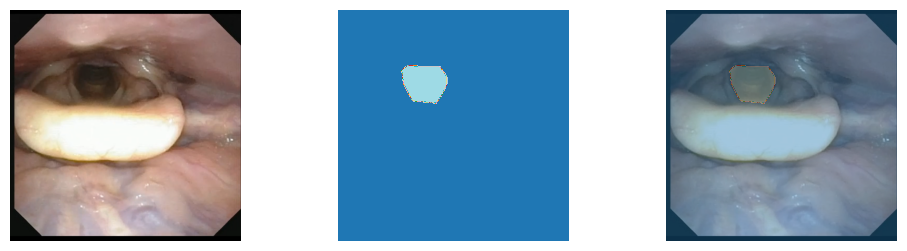

In [ ]:
plot_image_with_mask(image_files[0])

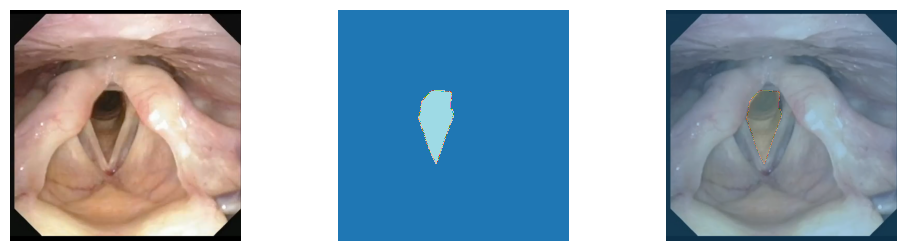

In [ ]:
plot_image_with_mask(image_files[1])

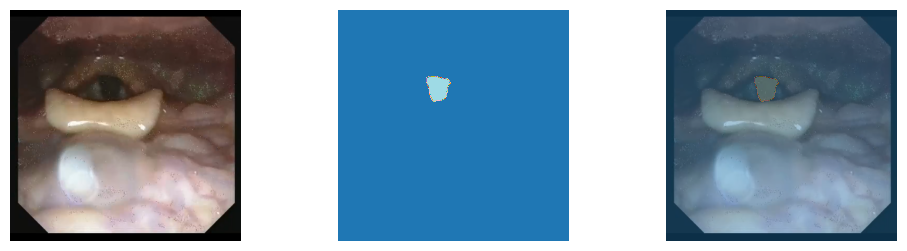

In [ ]:
plot_image_with_mask(image_files[2])

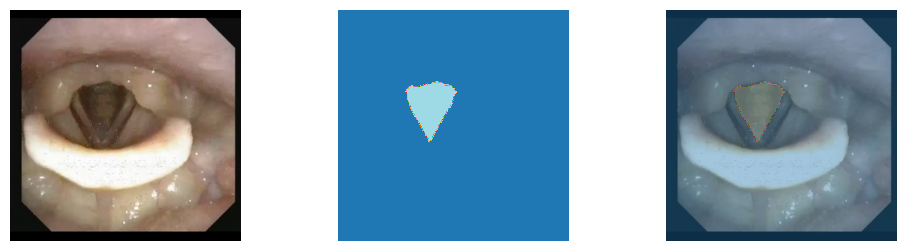

In [ ]:
plot_image_with_mask(test_images[0], test=True)

In [ ]:
num_train_images = len(image_files)
print('Number of train images: ', num_train_images)
num_test_images = len(test_images)
print('Number of test images: ', num_test_images)

Number of train images:  259
Number of test images:  23


In [ ]:
print(f'Image sizes: {Image.open(image_files[0]).size}')

Image sizes: (884, 884)


## 💾 Create DataLoaders

Creating the DataBlock

In [ ]:
image_block = DataBlock(
    blocks=(ImageBlock, MaskBlock([0, 1])),
    splitter=RandomSplitter(valid_pct=0.3, seed=42),
    get_items=get_image_files,
    get_y=get_mask_fn
)

... and getting the dataloaders

In [ ]:
dls = image_block.dataloaders(images, bs=4)

Examples from the validation set

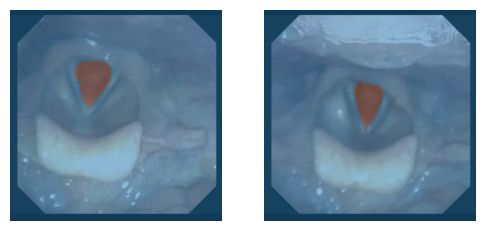

In [ ]:
dls.valid.show_batch()

## 📚 Learn

Creating the learner. Using an UNet learner on the resnet18 architecture.

In [ ]:
learner = unet_learner(dls, models.resnet18, n_out=2, metrics=[Dice], cbs=EarlyStoppingCallback(patience=2))

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


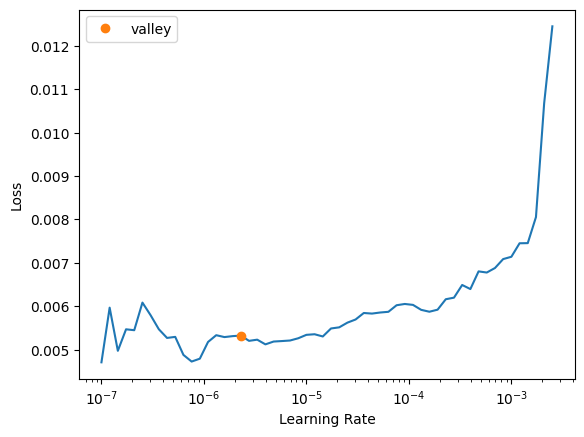

In [ ]:
lr_valley, _ = learner.lr_find()

Fine-tuning the model on the training data

In [ ]:
learner.fine_tune(5, base_lr=lr_valley)

epoch,train_loss,valid_loss,dice,time
0,0.008116,0.011675,0.901908,01:51


epoch,train_loss,valid_loss,dice,time
0,0.007576,0.011347,0.893741,01:53
1,0.007024,0.010709,0.910014,01:53
2,0.006640,0.010321,0.910046,01:53
3,0.006008,0.010128,0.910977,01:53
4,0.005898,0.010144,0.912649,01:53


## ✅ Results

Some of the prediction results

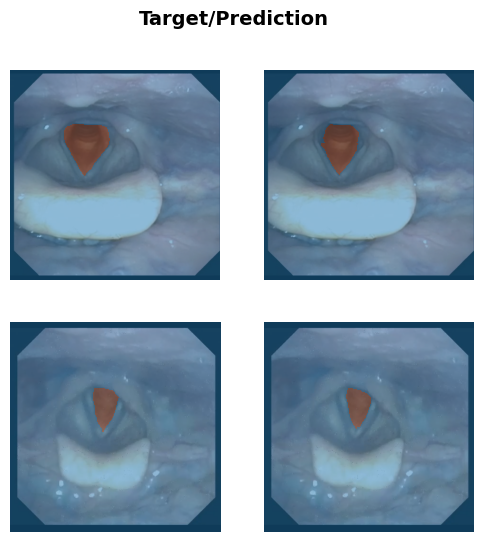

In [ ]:
learner.show_results()

Creating a function for predicting using the trained model and plotting the results

In [ ]:
def plot_larynx_opening_prediction(img_path, preds=None):
  if preds is None:
    preds = learner.predict(img_path)[0]

  pil_image = PILImage.create(img_path)
  pil_mask = PILMask.create(preds)

  _,axs = plt.subplots(1,3, figsize=(12,3))
  pil_image.show(ctx=axs[0], figsize=(5,5), alpha=1)
  pil_mask.show(ctx=axs[1], figsize=(5,5), alpha=1)

  pil_image.show(ctx=axs[2], figsize=(5,5), alpha=1)
  pil_mask.show(ctx=axs[2], figsize=(5,5), alpha=0.4)

Testing the function on an image from the test set

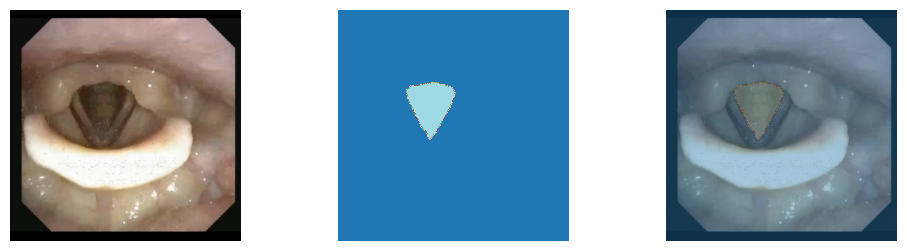

In [ ]:
plot_larynx_opening_prediction(test_images[0])

In [ ]:
learner.export('model.pkl')

## 🔬 Evaluation

Contains different methods for evaluating the model

### Evaluate next frames

As the first method for evaluating the model we do predictions on some of the next frames from two of the videos used in training. The model is only trained on frames with a lower timestamp than these images. Thus, this simulate the model performance for the upcoming frames when having the previous segmented frames in memory.

#### Get data zip

Get next frame test data from '**next_frame_test_0.2.zip**'

In [ ]:
next_frame_test_path = unzip_data('next_frame_test_0.2')
id5_test_path = next_frame_test_path/'ID5_test'
id7_test_path = next_frame_test_path/'ID7_test'

#### Evaluate next frames

In [ ]:
def plot_next_frame_predictions(path):
  next_frame_images = get_image_files(path)
  for img in next_frame_images:
    plot_larynx_opening_prediction(img)

ID5

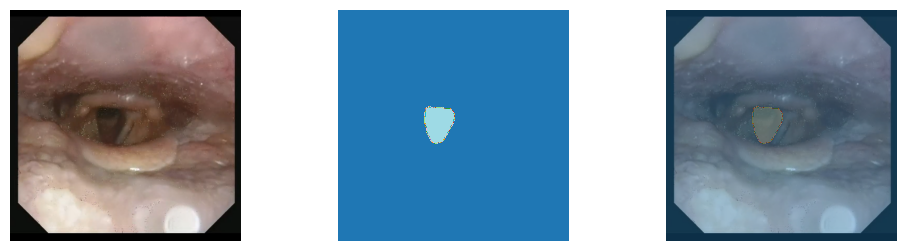

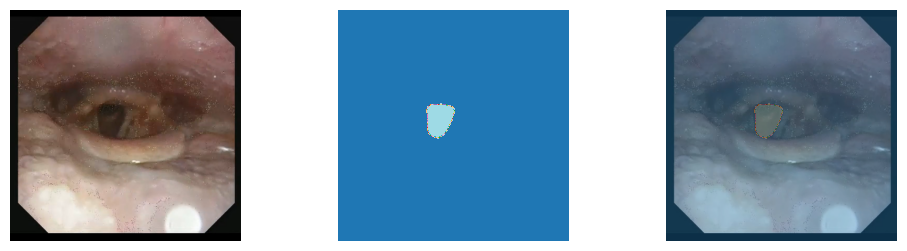

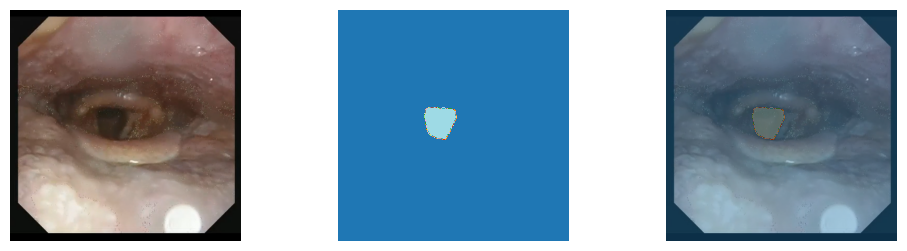

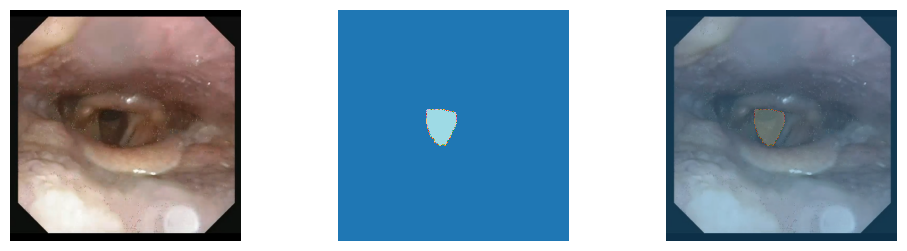

In [ ]:
plot_next_frame_predictions(id5_test_path)

ID5 gives pretty good predictions for 3/4 of the frames. Frame number 2 is partial correct but misses out on some significant pixels.

ID7

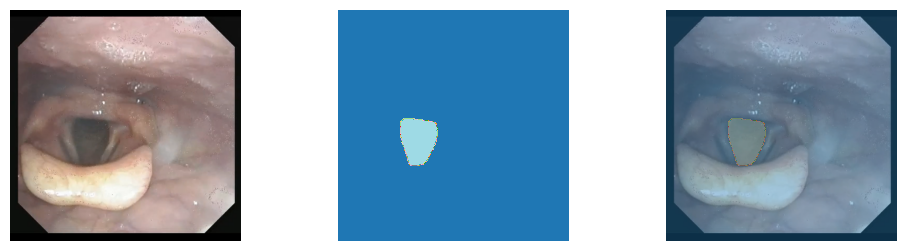

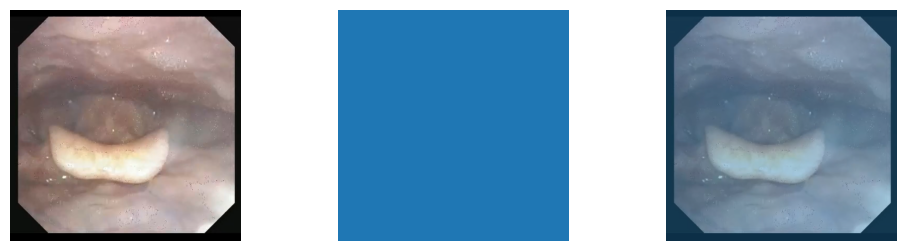

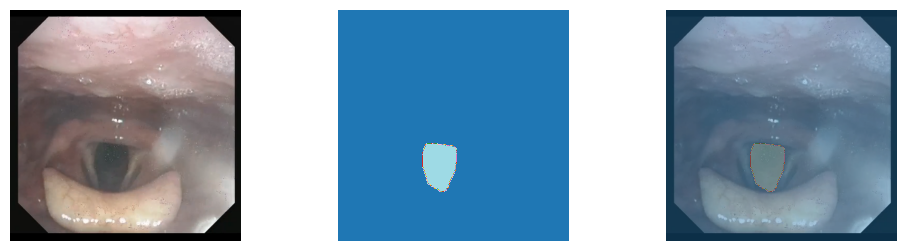

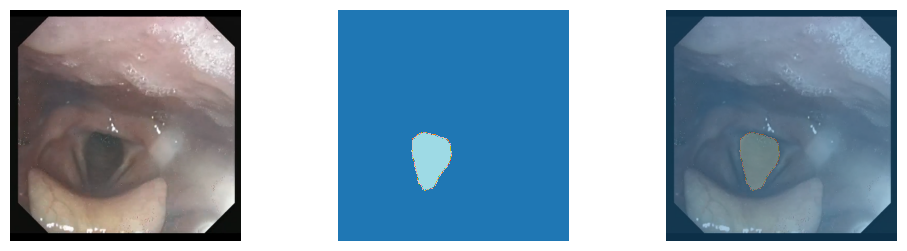

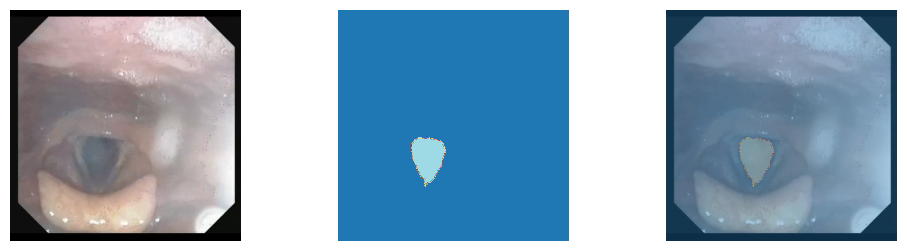

In [ ]:
plot_next_frame_predictions(id7_test_path)

Even better results for ID7. All of them are pretty good.

This shows that the model could perform well on the next frames if it knows a true prediction for some of the first frames of a video. For diagnostics the doctor could for example label some of the first frames manually and then let the model predict the rest.

### Evaluate using test set

Creating a function for predicting dice score for an unseen test image. Using ***torchmetrics*** due to difficulties using fast.ai's built-in methods for predicting test data.

In [ ]:
!pip install torchmetrics
from torchmetrics import Dice

def predict_larynx_opening_and_get_dice_score_pytorch(img_path):
  target = get_mask_fn_test(img_path)
  preds = learner.predict(img_path)[0]

  #print(np.average(np.array(target == preds))) # gives approx. same results as Dice()
  dice = Dice(average='samples')
  return (dice(preds, target), preds)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 9.5 MB/s eta 0:00:00


In [ ]:
def test_dice_score_predictor(test_image):
  score, preds = predict_larynx_opening_and_get_dice_score_pytorch(test_image)
  print("Dice score: " + str(score))
  print('Target (1), Prediction (2)')
  plot_image_with_mask(test_image, test=True)
  plot_larynx_opening_prediction(test_image, preds=preds)

Trying out the function on an example image from the test data: Even though the dice score seem to be exceptionally good, the plots shows that the prediction is not that good. The area which it misses out on is roughly 1% of the whole image area. This makes the score not that impressive.

Dice score: TensorMask(0.9821)
Target (1), Prediction (2)


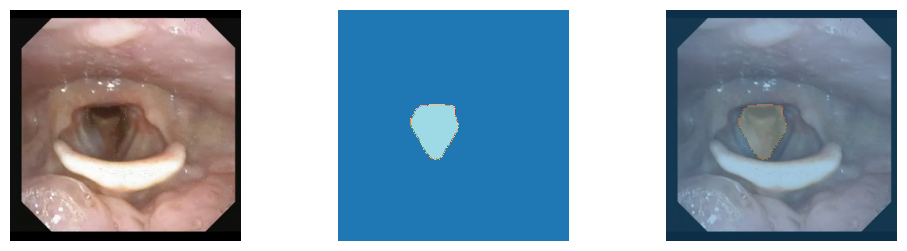

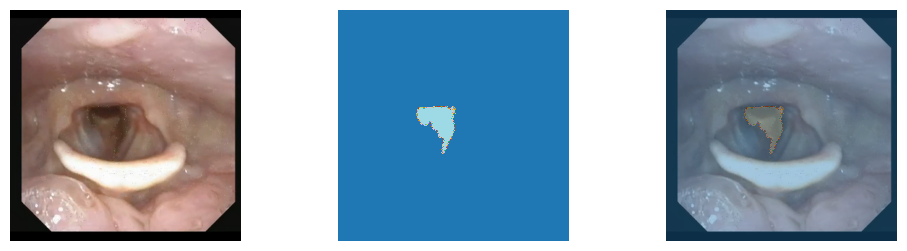

In [ ]:
test_dice_score_predictor(test_images[15])

Let's predict on another test image. This one gives a much more accurate result. The dice score is 0.9970.

Dice score: TensorMask(0.9978)
Target (1), Prediction (2)


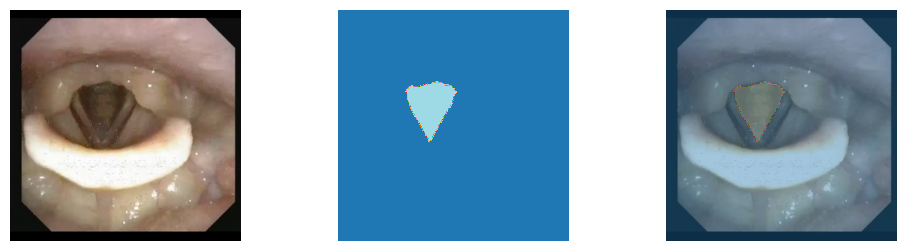

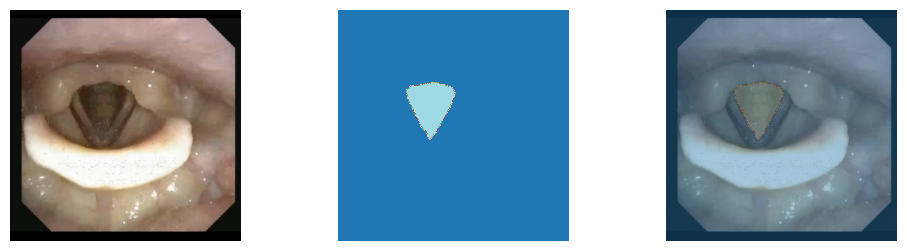

In [ ]:
test_dice_score_predictor(test_images[0])

Another good prediction with a score of 0.9849.

Dice score: TensorMask(0.9926)
Target (1), Prediction (2)


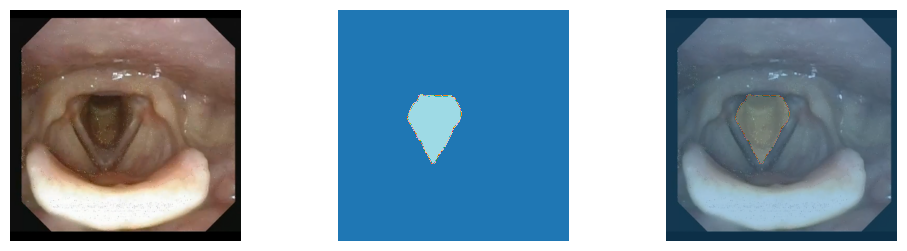

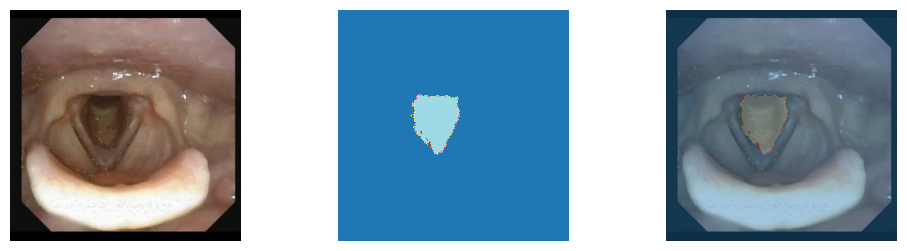

In [ ]:
test_dice_score_predictor(test_images[7])

From this, the test set evaluation will be great if the average dice score is at least 0.99 +/- 0.5 depending on the size of the true prediction area.

In [ ]:
def evaluate_learner(data):
  preds = np.array([])
  for x in data:
    score, _ = predict_larynx_opening_and_get_dice_score_pytorch(x)
    preds = np.append(score, preds)
  return np.average(preds)

In [ ]:
print("Average dice score on test data: " + str(evaluate_learner(test_images)))

Average dice score on test data: 0.9921029780222022


Based on latter cells this a good dice score for unseen data!

If I had time I would optimally use another metric for calculating performance score. Bad results being ~0.98 and good ones a ~0.99 makes this a bit weird. Also, the score will be based on the actual size of the prediction area. If we have a very small area which is the target, the metric does not penatilize missed area from the model that much compared to larger target areas. If the target area is large it gets penatilized a lot for missing out on some pixels.